In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import nltk

In [3]:
nltk.download('punkt')
df = pd.read_csv('dados.csv')
df.head()
sent_tokenize(df['descricao'].iloc[0])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriel_Germano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Que a diretoria da CENAPET, em conjunto com a FORGRAD e a ANDIFES, pressionem o MEC (FNDE) para que o custeio seja destinado aos grupos PET, no seu valor INTEGRAL, no início do ano fiscal, no máximo até 01/março para seu gasto até 15/outubro, com prestação de contas até 30/outubro do mesmo ano fiscal vigente.']

In [4]:
# create a new dataframe with the id and the tokenized description
new_df = pd.DataFrame()
new_df['id'] = range(1, len(df))
new_df['evento'] = df['evento']
new_df['tokenized'] = df['descricao'].apply(lambda x: word_tokenize(x))

new_df.head()

,id,evento,tokenized
0,1,GDT 1 - ENAPET 2018,"[Que, a, diretoria, da, CENAPET, ,, em, conjun..."
1,2,GDT 1 - ENAPET 2018,"[Que, os, titulares, e, suplentes, do, Conselh..."
2,3,GDT 1 - ENAPET 2018,"[Que, a, diretoria, da, CENAPET, intervenha, j..."
3,4,GDT 1 - ENAPET 2018,"[Que, a, Diretoria, da, CENAPET, pressione, o,..."
4,5,GDT 1 - ENAPET 2018,"[Que, a, Diretoria, da, CENAPET, proponha, ao,..."


# Working with stopwords and tokenized words

In [5]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
# Remove pontuaction
new_df['tokenized'] = new_df['tokenized'].apply(lambda x: [word for word in x if word.isalnum()])
# Remove stopwords
new_df['no_stopwords'] = new_df['tokenized'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
new_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel_Germano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,evento,tokenized,no_stopwords
0,1,GDT 1 - ENAPET 2018,"[Que, a, diretoria, da, CENAPET, em, conjunto,...","[diretoria, CENAPET, conjunto, FORGRAD, ANDIFE..."
1,2,GDT 1 - ENAPET 2018,"[Que, os, titulares, e, suplentes, do, Conselh...","[titulares, suplentes, Conselho, Diretoria, CE..."
2,3,GDT 1 - ENAPET 2018,"[Que, a, diretoria, da, CENAPET, intervenha, j...","[diretoria, CENAPET, intervenha, junto, reuniõ..."
3,4,GDT 1 - ENAPET 2018,"[Que, a, Diretoria, da, CENAPET, pressione, o,...","[Diretoria, CENAPET, pressione, MEC, sentido, ..."
4,5,GDT 1 - ENAPET 2018,"[Que, a, Diretoria, da, CENAPET, proponha, ao,...","[Diretoria, CENAPET, proponha, MEC, acesso, Si..."


## Using linear_kernel to compare the database

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

In [24]:
results = new_df['no_stopwords'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(results)
similaridade_linear_set = set()

for i in range(len(new_df)):
    # Calcular a similaridade na base de dados
    similaridade_linear = linear_kernel(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    # Zerar a similaridade para o próprio index
    similaridade_linear[i] = 0
    # Obter o índice do maior valor
    most_similar = np.argmax(similaridade_linear)
    
    most_similar_value = similaridade_linear[most_similar]
    
    most_similar_text = new_df['no_stopwords'].iloc[most_similar]

    similaridade_linear_set.add(most_similar_value)
    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.18334745608261052
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['CLAA', 'respectivas', 'IES', 'fiscalizem', 'partir', '2019', 'cada', 'ano', 'meio', 'listas',

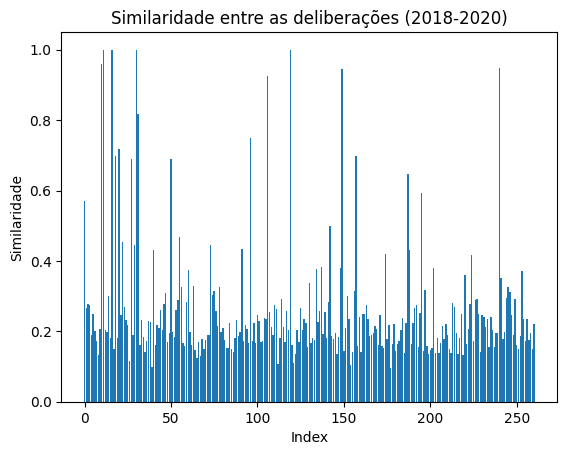

In [26]:
import matplotlib.pyplot as plt
plt.bar(range(len(similaridade_linear_set)), similaridade_linear_set)
plt.xlabel('Index')
plt.ylabel('Similaridade')
plt.title('Similaridade entre as deliberações (2018-2020)')
plt.show()

## Using cosine similarity

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

results = new_df['no_stopwords'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(results)
similaridade_cosseno_set = set()

for i in range(len(new_df)):
    # Calcular a similaridade na base de dados
    similaridade_cosseno = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    # Zerar a similaridade para o próprio index
    similaridade_cosseno[i] = 0
    # Obter o índice do maior valor
    most_similar = np.argmax(similaridade_cosseno)
    
    most_similar_value = similaridade_cosseno[most_similar]
    
    most_similar_text = new_df['no_stopwords'].iloc[most_similar]

    similaridade_cosseno_set.add(most_similar_value)
    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.18334745608261058
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['CLAA', 'respectivas', 'IES', 'fiscalizem', 'partir', '2019', 'cada', 'ano', 'meio', 'listas',

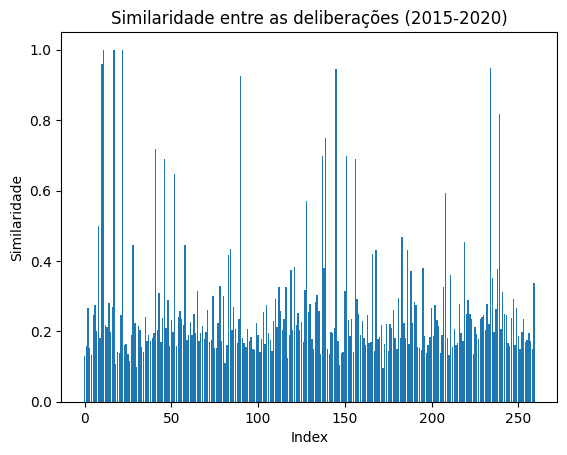

In [28]:
from matplotlib import pyplot as plt
plt.bar(range(len(similaridade_cosseno_set)), similaridade_cosseno_set)
plt.xlabel('Index')
plt.ylabel('Similaridade')
plt.title('Similaridade entre as deliberações (2015-2020)')
plt.show()

## Using Kernel RBF algorithm

In [17]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

results = new_df['no_stopwords'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(results)

# Calcular a matriz de similaridade RBF uma única vez
similaridade_rbf = rbf_kernel(tfidf_matrix, tfidf_matrix)

similaridades_rbf_set = set()

for i in range(len(new_df)):
    similaridade_rbf[i, i] = 0  # Zerar a similaridade do documento com ele mesmo
    most_similar = np.argmax(similaridade_rbf[i])
    most_similar_value = similaridade_rbf[i, most_similar]
    most_similar_text = new_df['no_stopwords'].iloc[most_similar]
    similaridades_rbf_set.add(most_similar_value)

    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.9995287387587567
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['CLAA', 'respectivas', 'IES', 'fiscalizem', 'partir', '2019', 'cada', 'ano', 'meio', 'listas', 

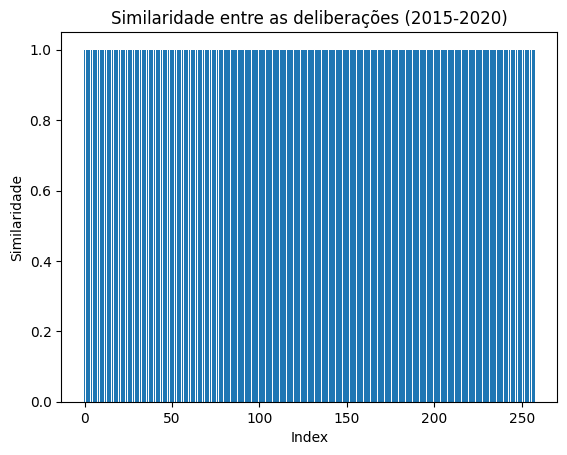

In [18]:
import matplotlib.pyplot as plt
plt.bar(range(len(similaridades_rbf_set)), similaridades_rbf_set)
plt.xlabel('Index')
plt.ylabel('Similaridade')
plt.title('Similaridade entre as deliberações (2015-2020)')
plt.show()

# ESSE GRAFICO TA MT ESTRANHO KKKKKKKKKKKKKK

## Using Manhattan Distance

In [20]:
from sklearn.metrics.pairwise import manhattan_distances
import numpy as np

similaridade_manhattan_set = set()

for i in range(len(new_df)):
    # Calcular a distância de Manhattan na base de dados
    similaridade_manhattan = manhattan_distances(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    # Zerar a distância para o próprio index para evitar auto-seleção
    similaridade_manhattan[i] = np.inf  # Usar np.inf para garantir que este valor seja o maior possível
    # Obter o índice do menor valor, que indica a menor distância e, portanto, o texto mais similar
    most_similar = np.argmin(similaridade_manhattan)
    
    most_similar_value = similaridade_manhattan[most_similar]
    most_similar_text = new_df['no_stopwords'].iloc[most_similar]
    similaridade_manhattan_set.add(most_similar_value)
    
    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar]}")
    print(f"Distância de Manhattan: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Distância de Manhattan: 6.1711786910537345
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['grupos', 'PET', 'registrem', 'atividades', 'extensão', 'PET', 'Extensão', 'assim', '

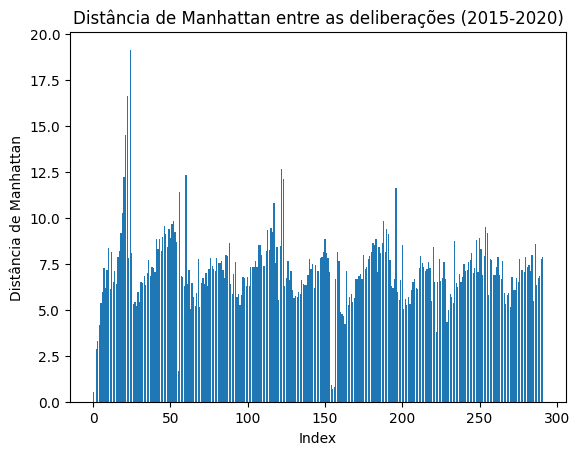

In [22]:
# A distância de Manhattan é uma métrica de distância que mede a soma das diferenças absolutas entre os elementos dos vetores.
# Quanto menor a distância, mais similar são os textos.
# Plotar um gráfico de barras para visualizar as distâncias
import matplotlib.pyplot as plt
plt.bar(range(len(similaridade_manhattan_set)), similaridade_manhattan_set)
plt.xlabel('Index')
plt.ylabel('Distância de Manhattan')
plt.title('Distância de Manhattan entre as deliberações (2015-2020)')
plt.show()

## Using euclidean distance from Scipy

In [40]:
from scipy.spatial.distance import euclidean
import numpy as np

similaridade_euclidiana_set = set()

for i in range(len(new_df)):
    # Calcular a distância euclidiana na base de dados
    distancias_euclidianas = [euclidean(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[j].toarray().flatten()) for j in range(len(new_df))]
    # Zerar a distância para o próprio index para evitar auto-seleção
    distancias_euclidianas[i] = np.inf  # Usar np.inf para garantir que este valor seja o maior possível
    
    # Converter distâncias em similaridades
    similaridades = [1 / (1 + d) for d in distancias_euclidianas]  # Adiciona 1 para evitar divisão por zero
    
    # Obter o índice do maior valor de similaridade, que indica o texto mais similar
    most_similar_index = np.argmax(similaridades)
    most_similar_value = similaridades[most_similar_index]
    most_similar_text = new_df['no_stopwords'].iloc[most_similar_index]
    
    # Adicionar o valor de similaridade ao conjunto
    similaridade_euclidiana_set.add(most_similar_value)
    
    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar_index]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.438979972907614
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['CLAA', 'respectivas', 'IES', 'fiscalizem', 'partir', '2019', 'cada', 'ano', 'meio', 'listas', '

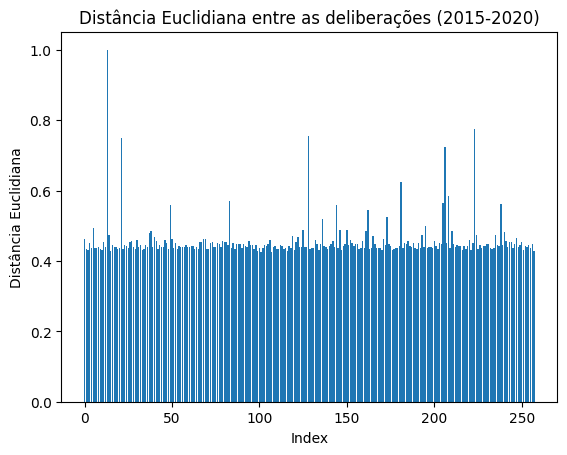

In [41]:
import matplotlib.pyplot as plt
plt.bar(range(len(similaridade_euclidiana_set)), similaridade_euclidiana_set)
plt.xlabel('Index') 
plt.ylabel('Distância Euclidiana')
plt.title('Distância Euclidiana entre as deliberações (2015-2020)')
plt.show()

# Nesse caso quanto mais próximo de 1, mais similar são os textos
# A distância euclidiana é uma métrica de distância que mede a distância entre dois pontos em um espaço euclidiano.

## Using Cityblock distance from Scipy

In [45]:
from scipy.spatial.distance import cityblock
import numpy as np

similaridade_cityblock_set = set()

for i in range(len(new_df)):
    # Calcular a distância de cityblock na base de dados
    distancias_cityblock = [cityblock(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[j].toarray().flatten()) for j in range(len(new_df))]
    # Zerar a distância para o próprio index para evitar auto-seleção
    distancias_cityblock[i] = np.inf  # Usar np.inf para garantir que este valor seja o maior possível
    
    # Converter distâncias em similaridades
    similaridades = [1 / (1 + d) for d in distancias_cityblock]  # Adiciona 1 para evitar divisão por zero
    
    # Obter o índice do maior valor de similaridade, que indica o texto mais similar
    most_similar_index = np.argmax(similaridades)
    most_similar_value = similaridades[most_similar_index]
    most_similar_text = new_df['no_stopwords'].iloc[most_similar_index]
    
    # Adicionar o valor de similaridade ao conjunto
    similaridade_cityblock_set.add(most_similar_value)
    
    print(f"Texto: {new_df['no_stopwords'].iloc[i]}, evento: {new_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {new_df['evento'].iloc[most_similar_index]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinado', 'grupos', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'máximo', 'gasto', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['Diretoria', 'CENAPET', 'pressione', 'MEC', 'sentido', 'pagas', 'duas', 'parcelas', 'custeio', 'primeira', 'parcela', 'paga', 'início', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.13944708995294322
-----
Texto: ['titulares', 'suplentes', 'Conselho', 'Diretoria', 'CENAPET', 'convidados', 'comparecer', 'eventos', 'regionais', 'respectivas', 'regiões', 'eventos', 'nacionais', 'durante', 'períodos', 'mandato', 'caso', 'impossibilidade', 'providenciar', 'alguma', 'ação', 'informe', 'atribuições', 'ações', 'realizados', 'data', 'evento'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['grupos', 'PET', 'registrem', 'atividades', 'extensão', 'PET', 'Extensão', 'assim', 'ações', '

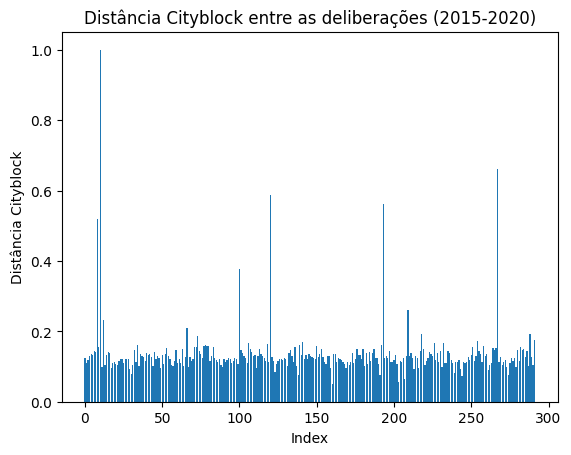

In [46]:
import matplotlib.pyplot as plt
plt.bar(range(len(similaridade_cityblock_set)), similaridade_cityblock_set)
plt.xlabel('Index')
plt.ylabel('Distância Cityblock')
plt.title('Distância Cityblock entre as deliberações (2015-2020)')
plt.show()

## Comparing the algorithms

In [37]:
from scipy.stats import pearsonr

# Convert sets to lists to enable slicing
similaridade_linear_list = list(similaridade_linear_set)
similaridades_cosseno_list = list(similaridade_cosseno_set)
similaridades_rbf_list = list(similaridades_rbf_set)
similaridade_manhattan_list = list(similaridade_manhattan_set)

# Ensure both lists have the same size for linear vs. cosine comparison
min_length_linear_cosine = min(len(similaridade_linear_list), len(similaridades_cosseno_list))
similaridade_linear_list_fit = similaridade_linear_list[:min_length_linear_cosine]
similaridades_cosseno_list_fit = similaridades_cosseno_list[:min_length_linear_cosine]

# Ensure both lists have the same size for RBF vs. Manhattan comparison
min_length_rbf_manhattan = min(len(similaridades_rbf_list), len(similaridade_manhattan_list))
similaridades_rbf_list_fit = similaridades_rbf_list[:min_length_rbf_manhattan]
similaridade_manhattan_list_fit = similaridade_manhattan_list[:min_length_rbf_manhattan]

# Calculate Pearson correlation with equally sized lists for linear vs. cosine
correlacao_pearson_linear_cosine = pearsonr(similaridade_linear_list_fit, similaridades_cosseno_list_fit)

# Calculate Pearson correlation with equally sized lists for RBF vs. Manhattan
correlacao_pearson_rbf_manhattan = pearsonr(similaridades_rbf_list_fit, similaridade_manhattan_list_fit)

print(correlacao_pearson_linear_cosine)
print(correlacao_pearson_rbf_manhattan)

PearsonRResult(statistic=0.09839945958807593, pvalue=0.11345744736703336)
PearsonRResult(statistic=-0.03655723380947366, pvalue=0.5588568910467865)


# Working with lemmatization

In [120]:
import spacy
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     --------------------------------------- 0.0/13.0 MB 682.7 kB/s eta 0:00:19
     ---------------------------------------- 0.1/13.0 MB 1.2 MB/s eta 0:00:11
      --------------------------------------- 0.2/13.0 MB 1.8 MB/s eta 0:00:08
     - -------------------------------------- 0.3/13.0 MB 2.0 MB/s eta 0:00:07
     - -------------------------------------- 0.6/13.0 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/13.0 MB 3.4 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/13.0 MB 4.3 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/13.0 MB 5.6 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/13.0 MB 6.7 MB/s eta 0:00:02
     ------------ --------------------------- 4.2/13.0 MB 9.2 MB/s eta 0:00:01
     ----------------- ---------------------- 5.7/13.0 MB 11.3 MB/s eta 0:00:01
     ---------------------- ----------------- 7.2/13.0 MB

In [125]:
nlp = spacy.load('pt_core_news_sm')
print(nlp.component_names)

['tok2vec', 'morphologizer', 'parser', 'lemmatizer', 'senter', 'attribute_ruler', 'ner']


In [123]:
lem_df = pd.DataFrame()
lem_df['id'] = range(1, len(df))
lem_df['evento'] = df['evento']
lem_df['lemmatized'] = new_df['no_stopwords'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])
lem_df.head()

,id,evento,lemmatized
0,1,GDT 1 - ENAPET 2018,"[diretoria, CENAPET, conjunto, FORGRAD, ANDIFE..."
1,2,GDT 1 - ENAPET 2018,"[titular, suplente, Conselho, Diretoria, CENAP..."
2,3,GDT 1 - ENAPET 2018,"[diretoria, CENAPET, intervir, junto, reunião,..."
3,4,GDT 1 - ENAPET 2018,"[Diretoria, CENAPET, pressione, MEC, senter, p..."
4,5,GDT 1 - ENAPET 2018,"[Diretoria, CENAPET, propor, MEC, acesso, Sist..."


## Using linear_kernel to verify similarities

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

In [127]:
results = lem_df['lemmatized'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(results)
similarities = set()

for i in range(len(new_df)):
    # Calcular a similaridade do cosseno na base de dados
    cosine_similarities = linear_kernel(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    # Zerar a similaridade do cosseno para o próprio index
    cosine_similarities[i] = 0
    # Obter o índice do maior valor
    most_similar = np.argmax(cosine_similarities)
    
    most_similar_value = cosine_similarities[most_similar]
    
    most_similar_text = lem_df['lemmatized'].iloc[most_similar]

    similarities.add(most_similar_value)
    print(f"Texto: {lem_df['lemmatized'].iloc[i]}, evento: {lem_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {lem_df['evento'].iloc[most_similar]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diretoria', 'CENAPET', 'conjunto', 'FORGRAD', 'ANDIFES', 'pressionem', 'MEC', 'FNDE', 'custeio', 'destinar', 'grupo', 'PET', 'valor', 'INTEGRAL', 'início', 'ano', 'fiscal', 'grande', 'gastar', 'prestação', 'contas', 'ano', 'fiscal', 'vigente'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['partir', 'XXV', 'ENAPET', 'CENAPET', 'incluar', 'Diretrizes', 'Organizações', 'evento', 'orientação', 'Comissões', 'Organizadoras', 'evento', 'regional', 'Nacional', 'PET', 'compiler', 'encaminhamento', 'sugestão', 'ATA', 'Oficial', 'acordo', 'instância', 'dever', 'destinado', 'destinar', 'Diretoria', 'CENAPET', 'destinar', 'conselho', 'CENAPET', 'destinar', 'Mobiliza', 'PET', 'destinar', 'CLAA', 'destinar', 'Grupos', 'PETs', 'outro'], evento: GDT 1 - Construção de Eventos PET - ENAPET 2020
Similaridade: 0.17459825123618944
-----
Texto: ['titular', 'suplente', 'Conselho', 'Diretoria', 'CENAPET', 'convidar', 'comparecer', 'evento', 'regional', 'respectivo', 'região', 'evento', 'naciona

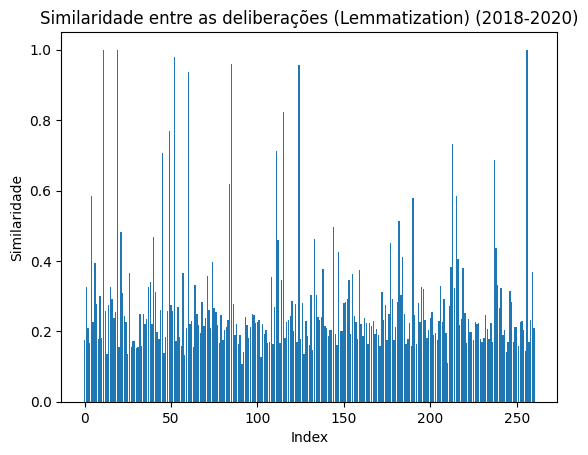

In [128]:
import matplotlib.pyplot as plt
plt.bar(range(len(similarities)), similarities)
plt.xlabel('Index')
plt.ylabel('Similaridade')
plt.title('Similaridade entre as deliberações (Lemmatization) (2018-2020)')
plt.show()

# Working with stemmatization

In [118]:
stem_df = pd.DataFrame()
stem_df['id'] = range(1, len(df))
stem_df['evento'] = df['evento']
stem_df['stemmed'] = new_df['no_stopwords'].apply(lambda x: [nltk.stem.RSLPStemmer().stem(word) for word in x])
stem_df.head()

,id,evento,stemmed
0,1,GDT 1 - ENAPET 2018,"[diret, cenapet, conjunt, forgrad, andif, pres..."
1,2,GDT 1 - ENAPET 2018,"[titul, supl, conselh, diret, cenapet, convid,..."
2,3,GDT 1 - ENAPET 2018,"[diret, cenapet, intervenh, junt, reun, subseq..."
3,4,GDT 1 - ENAPET 2018,"[diret, cenapet, pression, mec, sent, pag, dua..."
4,5,GDT 1 - ENAPET 2018,"[diret, cenapet, proponh, mec, acess, sistem, ..."


In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

In [130]:
results = stem_df['stemmed'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(results)
similarities = set()

for i in range(len(new_df)):
    # Calcular a similaridade do cosseno na base de dados
    cosine_similarities = linear_kernel(tfidf_matrix[i:i+1], tfidf_matrix).flatten()
    # Zerar a similaridade do cosseno para o próprio index
    cosine_similarities[i] = 0
    # Obter o índice do maior valor
    most_similar = np.argmax(cosine_similarities)
    
    most_similar_value = cosine_similarities[most_similar]
    
    most_similar_text = stem_df['stemmed'].iloc[most_similar]

    similarities.add(most_similar_value)
    print(f"Texto: {stem_df['stemmed'].iloc[i]}, evento: {stem_df['evento'].iloc[i]}")
    print(f"Texto mais semelhante: {most_similar_text}, evento: {stem_df['evento'].iloc[most_similar]}")
    print(f"Similaridade: {most_similar_value}")
    print("-----")

Texto: ['diret', 'cenapet', 'conjunt', 'forgrad', 'andif', 'pression', 'mec', 'fnd', 'custei', 'destin', 'grup', 'pet', 'val', 'integr', 'iníci', 'ano', 'fiscal', 'máx', 'gast', 'prest', 'cont', 'ano', 'fiscal', 'vigent'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['diret', 'cenapet', 'pression', 'mec', 'sent', 'pag', 'dua', 'parcel', 'custei', 'prim', 'parcel', 'pag', 'iníci', 'ano'], evento: GDT 1 - ENAPET 2018
Similaridade: 0.2385888999948123
-----
Texto: ['titul', 'supl', 'conselh', 'diret', 'cenapet', 'convid', 'comparec', 'event', 'region', 'respec', 'reg', 'event', 'nacion', 'dur', 'períod', 'mandat', 'cas', 'impossibil', 'providenci', 'algum', 'açã', 'inform', 'atribu', 'açõ', 'realiz', 'dat', 'event'], evento: GDT 1 - ENAPET 2018
Texto mais semelhante: ['encaminh', 'art', '25', 'ele', 'diret', 'hav', 'part', 'dat', 'fix', 'comiss', 'eleitor', 'divulg', 'chap', 'respec', 'program', 'tut', 'alun', 'eleit', 'vot', 'porém', 'eleit', 'titul', 'conselh', 'cad', 'encontr', '

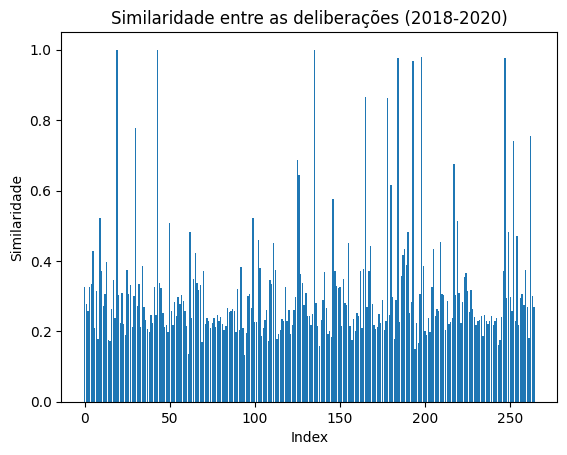

In [131]:
import matplotlib.pyplot as plt
plt.bar(range(len(similarities)), similarities)
plt.xlabel('Index')
plt.ylabel('Similaridade')
plt.title('Similaridade entre as deliberações (2018-2020)')
plt.show()

# Comparing the 3 tecniques

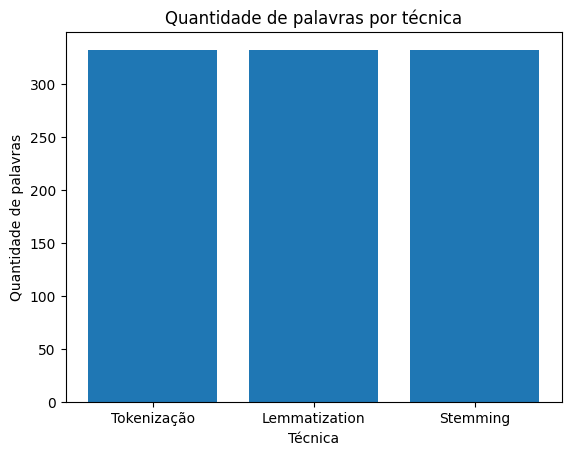

In [133]:
# Plotando o resultado das tecnicas usadas -> Tokenização, lemmatization e stemming
# Vamos usar os valores obtidos em cada técnica para comparar qual foi mais eficiente
import matplotlib.pyplot as plt

plt.bar(['Tokenização', 'Lemmatization', 'Stemming'], [new_df['no_stopwords'].apply(lambda x: ' '.join(x)).shape[0], lem_df['lemmatized'].apply(lambda x: ' '.join(x)).shape[0], stem_df['stemmed'].apply(lambda x: ' '.join(x)).shape[0]])
plt.xlabel('Técnica')
plt.ylabel('Quantidade de palavras')
plt.title('Quantidade de palavras por técnica')
plt.show()